In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/CS_231A/data/depth"

test  train  valid


In [3]:
import time
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

NUM_CLASSES = 11

input_size = (600, 600)

TRAIN_PATH = "/content/drive/MyDrive/CS_231A/data/depth_600/train"
VALID_PATH = "/content/drive/MyDrive/CS_231A/data/depth_600/valid"
TEST_PATH = "/content/drive/MyDrive/CS_231A/data/depth_600/test"

MODEL_NAME = "train4_efficient_depth_600_data"

def load_image(file):
    img = image.load_img(file, target_size=input_size)
    img_array = image.img_to_array(img)
    #import pdb; pdb.set_trace()
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

print(tf.version.VERSION)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


2.4.1
Num GPUs Available:  1


In [6]:
def create_model():
    #inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    #efficientNet = tf.keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_tensor=inputs)
    
    inputs = tf.keras.layers.Input(shape=(380, 380, 3))
    efficientNet = tf.keras.applications.EfficientNetB4(weights="imagenet", include_top=False, input_tensor=inputs)
    
    #inputs = tf.keras.layers.Input(shape=(600, 600, 3))
    #efficientNet = tf.keras.applications.EfficientNetB7(weights="imagenet", include_top=False, input_tensor=inputs)
    
    #print("Number of layers in the base model: ", len(efficientNet.layers))
    #print(efficientNet.summary())

    #x = efficientNet.layers[-2].output

    # Freeze the pretrained weights
    efficientNet.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(efficientNet.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    output = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs=efficientNet.input, outputs=output)

    # Freeze all the layers before the target layer
    '''
    for layer in model.layers[:200]:
      layer.trainable =  False
    '''

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Number of layers in modified model: ", len(model.layers))
    print(len(model.trainable_variables))
    #print(model.summary())
    return model

create_model()

71688192/71686520 [==============================] - 1s 0us/step
Number of layers in modified model:  478
4


In [26]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
%load_ext tensorboard
log_dir = "/content/drive/MyDrive/CS_231A/logs/train3_efficient_depth_380_data/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir "/content/drive/MyDrive/CS_231A/logs/train3_efficient_depth_380_data/"

In [63]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=TRAIN_PATH, target_size=input_size, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=VALID_PATH, target_size=input_size, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=TEST_PATH, target_size=input_size, batch_size=10, shuffle=False)
print(MODEL_NAME)

Found 933 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
Found 55 images belonging to 11 classes.
train4_efficient_depth_600_data


Number of layers in the base model:  813
Number of layers in modified model:  817
4
Epoch 1/60
94/94 - 118s - loss: 2.7263 - accuracy: 0.1168 - val_loss: 2.3962 - val_accuracy: 0.1136
Epoch 2/60
94/94 - 98s - loss: 2.6165 - accuracy: 0.1297 - val_loss: 2.3893 - val_accuracy: 0.0909
Epoch 3/60
94/94 - 98s - loss: 2.6075 - accuracy: 0.1533 - val_loss: 2.3578 - val_accuracy: 0.1364
Epoch 4/60
94/94 - 98s - loss: 2.6330 - accuracy: 0.1297 - val_loss: 2.3290 - val_accuracy: 0.1091
Epoch 5/60
94/94 - 98s - loss: 2.5343 - accuracy: 0.1608 - val_loss: 2.2860 - val_accuracy: 0.2227
Epoch 6/60
94/94 - 98s - loss: 2.5639 - accuracy: 0.1651 - val_loss: 2.2227 - val_accuracy: 0.1773
Epoch 7/60
94/94 - 98s - loss: 2.4486 - accuracy: 0.1865 - val_loss: 2.1570 - val_accuracy: 0.2636
Epoch 8/60
94/94 - 98s - loss: 2.5323 - accuracy: 0.1972 - val_loss: 2.1304 - val_accuracy: 0.2318
Epoch 9/60
94/94 - 98s - loss: 2.6199 - accuracy: 0.1651 - val_loss: 2.1230 - val_accuracy: 0.2364
Epoch 10/60
94/94 - 98s 

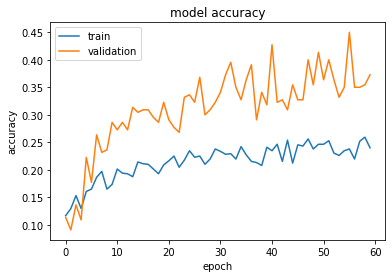

In [64]:
model = create_model()

start_time = time.time()

hist1 = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            #callbacks=[tensorboard_callback],
            epochs=60,
            verbose=2
)

end_time = time.time()

#model.save("/content/drive/My Drive/CS_231A/saved_models/" + MODEL_NAME)

print("Total training time: {} seconds".format(end_time - start_time))
print(model.summary())
plot_hist(hist1)


In [65]:
#model = tf.keras.models.load_model("/content/drive/My Drive/CS_231A/saved_models/train2_efficient_depth_data")
model.save("/content/drive/My Drive/CS_231A/saved_models/EfficientNetB7_base_stage1")

INFO:tensorflow:Assets written to: /content/drive/My Drive/CS_231A/saved_models/EfficientNetB7_base_stage1/assets


In [66]:
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 600, 600, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
normalization_7 (Normalization) (None, 600, 600, 3)  7           rescaling_7[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization_7[0][0]            
____________________________________________________________________________________________

In [68]:
def finetune_model(model):
    # Unfreeze the top 20 layers, and leave BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

finetune_model(model)

In [69]:
hist2 = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=50,
            verbose=2
)

Epoch 1/50
94/94 - 125s - loss: 3.4715 - accuracy: 0.1479 - val_loss: 5.3368 - val_accuracy: 0.1500
Epoch 2/50
94/94 - 102s - loss: 2.7640 - accuracy: 0.1543 - val_loss: 4.9087 - val_accuracy: 0.1182
Epoch 3/50
94/94 - 102s - loss: 2.7199 - accuracy: 0.1833 - val_loss: 3.2685 - val_accuracy: 0.2182
Epoch 4/50
94/94 - 102s - loss: 2.5617 - accuracy: 0.1876 - val_loss: 2.6781 - val_accuracy: 0.1091
Epoch 5/50
94/94 - 102s - loss: 2.4474 - accuracy: 0.2272 - val_loss: 4.2864 - val_accuracy: 0.1136
Epoch 6/50
94/94 - 101s - loss: 2.4877 - accuracy: 0.2154 - val_loss: 3.9016 - val_accuracy: 0.1091
Epoch 7/50
94/94 - 102s - loss: 2.4929 - accuracy: 0.2176 - val_loss: 2.5629 - val_accuracy: 0.1955
Epoch 8/50
94/94 - 102s - loss: 2.2924 - accuracy: 0.2519 - val_loss: 3.4950 - val_accuracy: 0.1500
Epoch 9/50
94/94 - 101s - loss: 2.2052 - accuracy: 0.2690 - val_loss: 2.8792 - val_accuracy: 0.1864
Epoch 10/50
94/94 - 102s - loss: 2.3041 - accuracy: 0.2262 - val_loss: 5.4355 - val_accuracy: 0.0955

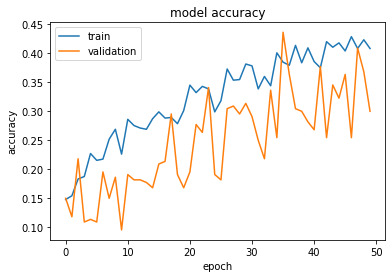

In [70]:
plot_hist(hist2)

In [71]:
test_labels = test_batches.classes
results = model.evaluate(test_batches, batch_size=128)
print("test loss, test acc:", results)

6/6 [==============================] - 5s 909ms/step - loss: 3.2482 - accuracy: 0.2182
test loss, test acc: [3.248167037963867, 0.2181818187236786]


In [59]:
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 380, 380, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
normalization_6 (Normalization) (None, 380, 380, 3)  7           rescaling_6[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization_6[0][0]            
____________________________________________________________________________________________